In [121]:
from collections import Counter
import copy
import re
import time

from bs4 import BeautifulSoup
import ebooklib
from ebooklib import epub
from jisho_api.word import Word as jisho_word
import matplotlib.pyplot as plt
import nagisa
import numpy as np
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
sns.set()

In [167]:
def get_translation_info(word):
    word_info = jisho_word.request(word)
    if not word_info.data or len(word_info.data) == 0:
        return None
    word_data = word_info.data[0]
    if word_data.japanese[0].word:
        jp_word = word_data.japanese[0].word
        jp_reading = word_data.japanese[0].reading
    else:
        jp_word = word_data.japanese[0].reading
        jp_reading = None

    return {
        'jp_word': jp_word,
        'jp_reading': jp_reading,
        'definition': '; '.join(word_data.senses[0].english_definitions),
        'jlpt_level': 'N/A',
        'common': word_data.is_common,
    }

In [2]:
def chapter_to_str(chapter):
    soup = BeautifulSoup(chapter.get_body_content(), 'html.parser')
    text = [para.get_text() for para in soup.find_all('p')]
    return ' '.join(text)

In [3]:
book = epub.read_epub('data/mushoku_tensei_raw.epub')
items = list(book.get_items_of_type(ebooklib.ITEM_DOCUMENT))

texts = {}
for item in tqdm(items):
    if '0' not in item.get_name():
        continue
    texts[item.get_name()] = chapter_to_str(item)

100%|██████████| 322/322 [01:11<00:00,  4.47it/s]


In [30]:
hiragana = '\u3040-\u309f'
katakana = '\u30a0-\u30ff'
kanji = '\u4e00-\u9faf'
syntax = '\u0021-\u002f'

def extract_japanese(text, incl_syntax=True):
    # Regex to extract Japanese and syntax characters
    if incl_syntax:
        return ''.join(re.findall(r'[{}]'.format(''.join([hiragana, katakana, kanji, syntax])), text))
    else:
        return ''.join(re.findall(r'[{}]'.format(''.join([hiragana, katakana, kanji])), text))

def contains_japanese(text):
    # Returns True if the text contains Japanese characters
    return len(extract_japanese(text, incl_syntax=False)) > 0

def contains_kanji(text):
    # Returns True if the text contains Japanese characters
    return re.search(r'[{}]'.format(kanji), text) is not None

In [17]:
# extract_japanese(texts['xhtml/0002.xhtml'])
# words = nagisa.tagging(extract_japanese(texts['xhtml/0002.xhtml']))
# words.words

In [7]:
# Loop though each text
# Extract the Japanese and syntactical characters
# Split the strings into words with Nagisa
# Keep a counter per chapter for all the words

chapter_tracker = {}
for text_name, text in tqdm(texts.items()):
    chapter_id = int(text_name.split('/')[1].split('.')[0])
    chapter_tracker[chapter_id] = Counter()
    for word in nagisa.tagging(extract_japanese(text)).words:
        if contains_japanese(word):
            chapter_tracker[chapter_id].update([word])

100%|██████████| 320/320 [14:28<00:00,  2.71s/it]


In [76]:
total_vocab = Counter()
for chapter_counter in chapter_tracker.values():
    total_vocab += chapter_counter
word_count = sum(total_vocab.values())
unique_word_count = len(total_vocab)
vocab_frac = {word: count / word_count for word, count in total_vocab.items()}

print('Word count: {}'.format(word_count))
print('Unique word count: {}'.format(unique_word_count))

Word count: 1507728
Unique word count: 36193


In [84]:
for percentile in range(10, 100, 10):
    print('{}% percentile: {}'.format(percentile, np.percentile(list(vocab_frac.values()), percentile)))

10% percentile: 6.632496047032356e-07
20% percentile: 6.632496047032356e-07
30% percentile: 6.632496047032356e-07
40% percentile: 6.632496047032356e-07
50% percentile: 1.3264992094064711e-06
60% percentile: 1.989748814109707e-06
70% percentile: 3.3162480235161784e-06
80% percentile: 5.969246442329121e-06
90% percentile: 1.5917990512877655e-05


In [89]:
def get_vocab_in_percentile(vocab, low, high):
    low_val, high_val = np.percentile(list(vocab.values()), [low, high])
    return {word: count for word, count in vocab.items() if low_val <= count <= high_val}

In [92]:
get_vocab_in_percentile(total_vocab, 90, 91)

{'目覚め': 28,
 'ページ': 28,
 'マスター': 25,
 '状': 28,
 '超': 25,
 '正義': 25,
 '挙句': 25,
 '面白': 25,
 '漫画': 28,
 '応援': 24,
 '以下': 27,
 '痛く': 25,
 '迫っ': 25,
 '引っ張っ': 24,
 'いよう': 25,
 'たっぷり': 24,
 '蓄え': 27,
 'ボンヤリ': 25,
 '事故': 27,
 '恩人': 25,
 '手足': 27,
 'てっきり': 24,
 'ハイ': 25,
 '雇っ': 25,
 '駆け寄っ': 25,
 '生命': 26,
 '処刑': 25,
 '離れる': 28,
 '餌': 28,
 '数多く': 27,
 '政治': 28,
 '快く': 27,
 '歓迎': 26,
 'スムーズ': 26,
 '冷や汗': 24,
 '暖かく': 26,
 '奇妙': 25,
 '伝わる': 25,
 '冊': 28,
 '篭っ': 26,
 'ドア': 25,
 '隙間': 26,
 '良': 27,
 '児': 25,
 '載っ': 24,
 '分け': 26,
 '体内': 26,
 '上位': 27,
 '疲労': 26,
 'ねい': 24,
 '構造': 26,
 '含ま': 26,
 'おぉ': 24,
 '浮い': 25,
 '設定': 26,
 '発射': 26,
 '頑張る': 25,
 '落とす': 27,
 '重ね': 26,
 '戸惑い': 28,
 '嬉しく': 26,
 '読み': 25,
 '早かっ': 26,
 '相場': 25,
 '若者': 28,
 'ヒゲ': 26,
 'ぜひ': 28,
 '高速': 26,
 '載せ': 27,
 '書き': 25,
 '慰め': 28,
 'いで': 26,
 '鍛錬': 27,
 '細かい': 26,
 'ただし': 25,
 '硬く': 24,
 '対象': 25,
 '半日': 28,
 '止まる': 27,
 '荒い': 24,
 'やすく': 26,
 'だて': 28,
 'エルフ': 27,
 '襲う': 25,
 '仕草': 28,
 '迫害': 26,
 '用事': 24,
 'フリ': 26,
 '刺激':

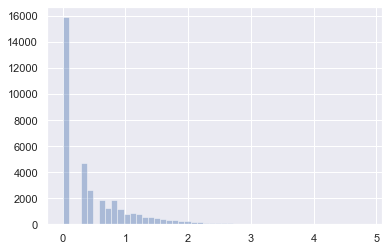

In [72]:
all_counts = np.array(list(total_vocab.values()))
sns.distplot(np.log10(all_counts), kde=False)

In [ ]:
contains_kanji('sdjhuifjhの 8')

False

In [59]:
total_vocab.most_common()[::-1]

[('編合わせ', 1),
 ('話今', 1),
 ('累計', 1),
 ('八十', 1),
 ('あとがき', 1),
 ('生まれ落ちる', 1),
 ('押し広げ', 1),
 ('降り立つ', 1),
 ('むか', 1),
 ('あげさ', 1),
 ('塗り替え', 1),
 ('中命', 1),
 ('あざ笑わ', 1),
 ('縋り付き', 1),
 ('跳ね落とさ', 1),
 ('小鳥', 1),
 ('さわさか', 1),
 ('かわさわさ', 1),
 ('ダル', 1),
 ('そっかいい', 1),
 ('取り上げる', 1),
 ('みえっ', 1),
 ('ナナ', 1),
 ('座り虚ろ', 1),
 ('ぺたん', 1),
 ('光召', 1),
 ('史', 1),
 ('さざなみ', 1),
 ('持ち真っ黒', 1),
 ('嫌誰', 1),
 ('絶え間', 1),
 ('蟻', 1),
 ('にげよう', 1),
 ('囚われる', 1),
 ('巻き戻せる', 1),
 ('老化', 1),
 ('徴用', 1),
 ('生きかえら', 1),
 ('否生まれ変わる', 1),
 ('否生まれる', 1),
 ('思い遠巻き', 1),
 ('映す', 1),
 ('勝ち誇り', 1),
 ('ちっしかし', 1),
 ('ダラけ', 1),
 ('害そう', 1),
 ('しろ孫', 1),
 ('思い残す', 1),
 ('髪入れ', 1),
 ('かくべつ', 1),
 ('いがみ合い', 1),
 ('勝つん', 1),
 ('ひっくり返す', 1),
 ('享年', 1),
 ('親しん', 1),
 ('薄弱', 1),
 ('ねそいつ', 1),
 ('クルール', 1),
 ('室長', 1),
 ('出版', 1),
 ('ブラッディ', 1),
 ('著ザノバ', 1),
 ('凡人', 1),
 ('自伝', 1),
 ('グレイラットルード', 1),
 ('著天', 1),
 ('史料', 1),
 ('アドルディアルード', 1),
 ('巡っ', 1),
 ('他数', 1),
 ('あがめ', 1),
 ('刊行', 1),
 ('妻魔', 1),
 ('妻長', 1),
 ('実

In [47]:
new_dict

Counter({'あらすじ': 1,
         '歳': 3,
         '職歴': 1,
         '無し': 1,
         '住所': 4,
         '不定': 3,
         '無職': 3,
         '童貞': 1,
         'の': 98,
         'ニート': 1,
         'は': 78,
         'ある': 4,
         '日家': 1,
         'を': 87,
         '追い出さ': 2,
         'れ': 23,
         '人生': 6,
         '後悔': 6,
         'し': 54,
         'て': 122,
         'いる': 14,
         '間': 2,
         'に': 118,
         'トラック': 12,
         '轢か': 1,
         '死ん': 4,
         'で': 65,
         'しまう': 1,
         '目覚め': 1,
         'た': 151,
         '時': 7,
         '彼': 4,
         '赤ん坊': 1,
         'なっ': 6,
         'い': 42,
         'どう': 5,
         'やら': 2,
         '異': 1,
         '世界': 2,
         '転生': 2,
         'らしい': 2,
         '誓う': 1,
         '今度': 1,
         'こそ': 2,
         '本気': 3,
         'だ': 40,
         'ない': 35,
         '送る': 1,
         'と': 74,
         '年': 10,
         '月': 1,
         '日': 1,
         '完結': 2,
         'まし': 2,
         '後': 5,
 

2597
